# NIP-Polish-Tax-Number


<b>Source website<b>: http://bnip.pl/

In [11]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

## Control panel

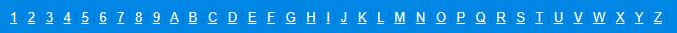

> <b>Enter your chosen page names:<b>

In [12]:
# Define page/pages:
pages = ['X']

In [13]:
# Format to string
pages= [str(item) for item in pages]
pages

['X']

## Webscraper

In [38]:
def scrape_detailed_info(session, url):
    "Detailed information from the page. - scraper"
    response = session.get(url)
    if response.encoding != 'ISO-8859-2':
        response.encoding = 'ISO-8859-2'
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        all_h1 = soup.find_all('h1')
        if len(all_h1) >= 1:
            company_name = all_h1[1].text.strip()
        else:
            company_name = "Company name not found"
        
        # Modification 
        company_name = company_name.replace('£', 'Ł').replace('¦', 'Ż').replace('¡', 'Ó').replace('³', 'ł')
        nip = soup.find('h2').text.strip()
        adres_element = soup.find('h2').find_next_siblings(text=True)
        adres = ''.join(adres_element).strip()
        return company_name, nip, adres
    else:
        return "Website download error", "", ""

# HTTP session initialization
session = requests.Session()

# DataFrame initialization
full_df = pd.DataFrame()


for item in pages:
    base_url = f'http://bnip.pl/nip,indexa,{item},{{}}.html'
    max_pages = None
    response = session.get(base_url.format(1))
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        p_elements = soup.find_all('p')
        for p in p_elements:
            matches = re.findall(r'(\d+)\<', p.text)
            if matches:
                max_pages = int(matches[-1])
    max_pages = max_pages or 1

    for page_number in range(1, max_pages + 1):
        # Information about the regular page
        print(f"Processing: ({item}, page {page_number} of {max_pages})")
        url = base_url.format(page_number)
        response = session.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            table = soup.find('table')
            if table:
                df = pd.read_html(str(table))[0]
                links = ['http://bnip.pl/' + a['href'] for a in soup.find_all('a', href=True) if 'a,nip,' in a['href']]
                df['Link'] = links[:len(df)]
                full_df = pd.concat([full_df, df], ignore_index=True)

for row in full_df.itertuples():
    url = getattr(row, 'Link')
    company_name, nip, adres = scrape_detailed_info(session, url)

    full_df.at[row.Index, 'Nazwa Firmy'] = company_name
    full_df.at[row.Index, 'NIP'] = nip
    full_df.at[row.Index, 'Adres'] = adres

full_df = full_df[['NIP', 'Link', 'Nazwa Firmy', 'Adres']]
# Close session
session.close()


Processing: (X, page 1 of 14)
Processing: (X, page 2 of 14)
Processing: (X, page 3 of 14)
Processing: (X, page 4 of 14)
Processing: (X, page 5 of 14)
Processing: (X, page 6 of 14)
Processing: (X, page 7 of 14)
Processing: (X, page 8 of 14)
Processing: (X, page 9 of 14)
Processing: (X, page 10 of 14)
Processing: (X, page 11 of 14)
Processing: (X, page 12 of 14)
Processing: (X, page 13 of 14)
Processing: (X, page 14 of 14)


In [39]:
full_df

,NIP,Link,Nazwa Firmy,Adres
0,NIP: 1010008104,"http://bnip.pl/a,nip,744685.html",XL CATLIN SERVICES SE SPÓŁKA EUROPEJSKA ODDZIA...,ul. Kazimierza Wielkiego 3\n50-077 Wrocław
1,NIP: 1070008467,"http://bnip.pl/a,nip,116984.html",XL TRADING SPÓŁKA Z OGRANICZONĄ ODPOWIEDZIALNO...,ul. Nadrzeczna 3 B /B-7\n05-552 Wólka Ko...
2,NIP: 1080000355,"http://bnip.pl/a,nip,77506.html",XL INSURANCE SPÓŁKA AKCYJNA ODDZIAŁ W POLSCE W...,ul. Nowy Świat 64\n00-357 Warszawa
3,NIP: 1130012083,"http://bnip.pl/a,nip,272390.html",XSEMONA JULITA GISZ,20/2\n05-462 Radiówek
4,NIP: 1130017229,"http://bnip.pl/a,nip,42717.html",XP SPÓŁKA Z OGRANICZONĄ ODPOWIEDZIALNOŚCIĄ,ul. Belgradzka\n02-793 Warszawa
...,...,...,...,...
680,NIP: 9730544438,"http://bnip.pl/a,nip,332349.html",XPERTS INŻ. SŁAWOMIR ŁADA,ul. Trasa Północna 12h\n65-119 Zielona Góra
681,NIP: 9730825516,"http://bnip.pl/a,nip,686361.html",XSEOX MARKETING ADAM KWIATKOWSKI,ul. Lipowa 27\n55-040 Królikowice
682,NIP: 9731071321,"http://bnip.pl/a,nip,695998.html",XRS GROUP SPÓŁKA Z OGRANICZONĄ ODPOWIEDZIALNOŚCIĄ,ul. Poznańska 18A\n65-137 Zielona Góra
683,NIP: 9910435805,"http://bnip.pl/a,nip,581864.html",XYZ Media Magdalena NOWAK,ul. Augustyna Kośnego 38/11\n45-056 Opole


# Output

> <b>Save to Excel or CSV<b>

In [ ]:
full_df.to_excel("NIP.xlsx")

In [40]:
full_df.to_csv("NIP.csv")